In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# !cp /content/gdrive/MyDrive/sem7btp/RGB.zip /content

In [2]:
!unzip  /content/gdrive/MyDrive/sem7btp/RGB.zip -d /content/

Archive:  /content/gdrive/MyDrive/sem7btp/RGB.zip
   creating: /content/RGB/
  inflating: /content/RGB/a10_s1_t1_color.avi  
  inflating: /content/RGB/a10_s1_t2_color.avi  
  inflating: /content/RGB/a10_s1_t3_color.avi  
  inflating: /content/RGB/a10_s1_t4_color.avi  
  inflating: /content/RGB/a10_s2_t1_color.avi  
  inflating: /content/RGB/a10_s2_t2_color.avi  
  inflating: /content/RGB/a10_s2_t3_color.avi  
  inflating: /content/RGB/a10_s2_t4_color.avi  
  inflating: /content/RGB/a10_s3_t1_color.avi  
  inflating: /content/RGB/a10_s3_t2_color.avi  
  inflating: /content/RGB/a10_s3_t3_color.avi  
  inflating: /content/RGB/a10_s3_t4_color.avi  
  inflating: /content/RGB/a10_s4_t1_color.avi  
  inflating: /content/RGB/a10_s4_t2_color.avi  
  inflating: /content/RGB/a10_s4_t3_color.avi  
  inflating: /content/RGB/a10_s4_t4_color.avi  
  inflating: /content/RGB/a10_s5_t1_color.avi  
  inflating: /content/RGB/a10_s5_t2_color.avi  
  inflating: /content/RGB/a10_s5_t3_color.avi  
  inflating

In [3]:
from glob import glob
all_files = []
for i in glob("/content/RGB/*"):
  all_files.append(i)

In [4]:
all_files[0].split('_')[0].split('/')[-1]

'a8'

In [5]:
all_tags = [i.split("_")[0].split("/")[-1] for i in all_files]
action_cat = list(set(all_tags))

In [6]:
import tensorflow as tf
import numpy as np
import os
import glob
import cv2
from sklearn.model_selection import train_test_split

data_dir = '/content/RGB'

# action_cat = ['Abuse', 'Arrest', 'Arson', 'Assault', 'RoadAccidents', 'Burglary', 'Explosion', 'Fighting', 'Robbery', 'Shooting', 'Stealing', 'Shoplifting', 'Vandalism']


In [7]:
import random
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame


In [ ]:
# @
def extract_frames(video_path,label):
  print(video_path,label)
  n_frames = 20
  output_size = (224,224)
  frame_step = 2
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  label = tf.cast(label, tf.float32)

  return result,label


In [8]:
BATCH_SIZE = 4
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (30, 128, 128, 3)
NUM_CLASSES = len(action_cat)

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 20

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 8

In [9]:
def frames_from_video_file(video_path, n_frames, output_size = (INPUT_SHAPE[1],INPUT_SHAPE[2]), frame_step = 2):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result


In [10]:

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(action_cat))#p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    # video_paths = glob.glob(os.path.join(data_dir,'*.avi'))#list(self.path.glob('/content/RGB/*.avi'))
    video_paths = self.path
    # classes = [p.parent.name for p in video_paths] 
    classes = [i.split("_")[0].split("/")[-1] for i in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [11]:
pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done



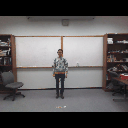

In [15]:
from tensorflow_docs.vis import embed
import imageio
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')

sample_video = frames_from_video_file('/content/RGB/a12_s7_t2_color.avi', n_frames = 30)
sample_video.shape

to_gif(sample_video)

In [ ]:
# For each video.
# def prepare_videos(files):
#     frame_labels = []
#     frame_features = np.zeros(
#             shape=(len(files),30, 224, 224, 3), dtype="float32"
#         )
#     for idx, path in enumerate(files):
#         print(idx,path)
#         video_frames = frames_from_video_file(path, INPUT_SHAPE[0])
        
#         # Extract features from the frames of the current video.
#         # frame_labels.append(path.split('_')[0].split('/')[-1])
#         frame_features[idx,] = video_frames
#     return frame_features#, np.array(frame_labels)


In [13]:
train_files, dummy_files, train_labels, dummy_labels = train_test_split(all_files, all_tags, test_size=0.3, stratify=all_tags, random_state=42)
test_files, valid_files, test_labels, valid_labels = train_test_split(dummy_files, dummy_labels, test_size=0.5, stratify=dummy_labels, random_state=42)
print(len(train_files),len(train_labels))
print(len(test_files),len(test_labels))
print(len(valid_files),len(valid_labels))

602 602
129 129
130 130


In [ ]:
# train_data = prepare_videos(train_files)

In [ ]:
# train_labels = np.array(train_labels)

In [14]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_files, INPUT_SHAPE[0], training=True),
                                          output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(FrameGenerator(valid_files, INPUT_SHAPE[0]),
                                        output_signature = output_signature)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_files, INPUT_SHAPE[0]),
                                        output_signature = output_signature)

In [15]:
next(iter(train_ds))[0].shape

TensorShape([30, 128, 128, 3])

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [17]:
next(iter(train_ds))[0].shape

TensorShape([4, 30, 128, 128, 3])

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [22]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

In [23]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    inputs = layers.Rescaling(scale=255)(inputs)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [26]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    # optimizer = keras.optimizers.Adamax()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
        # Train the model.
    _ = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

    _, accuracy, top_5_accuracy = model.evaluate(val_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model


In [27]:
model = run_experiment()

Epoch 1/20
151/151 [==============================] - 281s 2s/step - loss: 3.6298 - accuracy: 0.0249 - top-5-accuracy: 0.1561 - val_loss: 3.3811 - val_accuracy: 0.0347 - val_top-5-accuracy: 0.1853
Epoch 2/20
151/151 [==============================] - 32s 212ms/step - loss: 3.4326 - accuracy: 0.0332 - top-5-accuracy: 0.1761 - val_loss: 3.3724 - val_accuracy: 0.0347 - val_top-5-accuracy: 0.1853
Epoch 3/20
151/151 [==============================] - 33s 218ms/step - loss: 3.4060 - accuracy: 0.0299 - top-5-accuracy: 0.1694 - val_loss: 3.3667 - val_accuracy: 0.0347 - val_top-5-accuracy: 0.1815
Epoch 4/20
151/151 [==============================] - 33s 218ms/step - loss: 3.3904 - accuracy: 0.0233 - top-5-accuracy: 0.1728 - val_loss: 3.3572 - val_accuracy: 0.0347 - val_top-5-accuracy: 0.1969
Epoch 5/20
151/151 [==============================] - 32s 214ms/step - loss: 3.3777 - accuracy: 0.0249 - top-5-accuracy: 0.1794 - val_loss: 3.3427 - val_accuracy: 0.0347 - val_top-5-accuracy: 0.1969
Epoch 6

KeyboardInterrupt: ignored

In [18]:
pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 78.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=d5116c784679af773b3d6503527e54f39a64da9dce3fb52663a

In [19]:
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [20]:
model_id = 'a1'
resolution = INPUT_SHAPE[1]

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a1_base.tar.gz -O movinet_a1_base.tar.gz -q
!tar -xvf movinet_a1_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()


movinet_a1_base/
movinet_a1_base/checkpoint
movinet_a1_base/ckpt-1.data-00000-of-00001
movinet_a1_base/ckpt-1.index


In [21]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model


In [23]:
# import keras
model = build_classifier(BATCH_SIZE, INPUT_SHAPE[0], resolution, backbone, len(action_cat))
num_epochs = 30

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],)

In [24]:
results = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/30
151/151 [==============================] - 307s 2s/step - loss: 2.1048 - accuracy: 0.4086 - top-5-accuracy: 0.7608 - val_loss: 1.1446 - val_accuracy: 0.6385 - val_top-5-accuracy: 0.9769
Epoch 2/30
151/151 [==============================] - 20s 135ms/step - loss: 0.8359 - accuracy: 0.7492 - top-5-accuracy: 0.9751 - val_loss: 0.7065 - val_accuracy: 0.7538 - val_top-5-accuracy: 0.9923
Epoch 3/30
151/151 [==============================] - 18s 120ms/step - loss: 0.5003 - accuracy: 0.8455 - top-5-accuracy: 0.9967 - val_loss: 0.5544 - val_accuracy: 0.7923 - val_top-5-accuracy: 0.9923
Epoch 4/30
151/151 [==============================] - 18s 119ms/step - loss: 0.3350 - accuracy: 0.9003 - top-5-accuracy: 0.9983 - val_loss: 0.4742 - val_accuracy: 0.8154 - val_top-5-accuracy: 1.0000
Epoch 5/30
151/151 [==============================] - 18s 120ms/step - loss: 0.2343 - accuracy: 0.9286 - top-5-accuracy: 0.9983 - val_loss: 0.4129 - val_accuracy: 0.8385 - val_top-5-accuracy: 1.0000
Epoch 6

In [26]:
model.evaluate(test_ds)

33/33 [==============================] - 56s 2s/step - loss: 0.2459 - accuracy: 0.9457 - top-5-accuracy: 0.9922


[0.24592027068138123, 0.9457364082336426, 0.9922480583190918]

In [27]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [107]:
actions = '(1) right arm swipe to the left, (2) right arm swipe to the right, (3) right hand wave, (4) two hand front clap, (5) right arm throw, (6) cross arms in the chest, (7) basketball shoot, (8) right hand draw x, (9) right hand draw circle (clockwise), (10) right hand draw circle (counter clockwise), (11) draw triangle, (12) bowling (right hand), (13) front boxing, (14) baseball swing from right, (15) tennis right hand forehand swing, (16) arm curl (two arms), (17) tennis serve, (18) two hand push, (19) right hand knock on door, (20) right hand catch an object, (21) right hand pick up and throw, (22) jogging in place, (23) walking in place, (24) sit to stand, (25) stand to sit, (26) forward lunge (left foot forward), (27) squat (two arms stretch out)'
ACTION_LABELS = actions.split(',')
ACTION_LABELS = [label.split('(',1)[1] for label in ACTION_LABELS]
ACTION_LABELS = {'a'+label.split(')',1)[0]:label.split(')',1)[1].strip().capitalize() for label in ACTION_LABELS}


In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g', cmap = plt.get_cmap('Blues'))
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  tick_marks = np.arange(len(labels))
  plt.xticks(ticks=tick_marks,labels=labels,rotation=-90)
  plt.yticks(ticks=tick_marks,labels=labels,rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)


In [113]:
fg = FrameGenerator(train_files, INPUT_SHAPE[0], training=True)
label_names = list(fg.class_ids_for_name.keys())
label_names = [ACTION_LABELS[label] for label in label_names]

In [114]:
actual, predicted = get_actual_predicted_labels(test_ds)

33/33 [==============================] - 3s 95ms/step


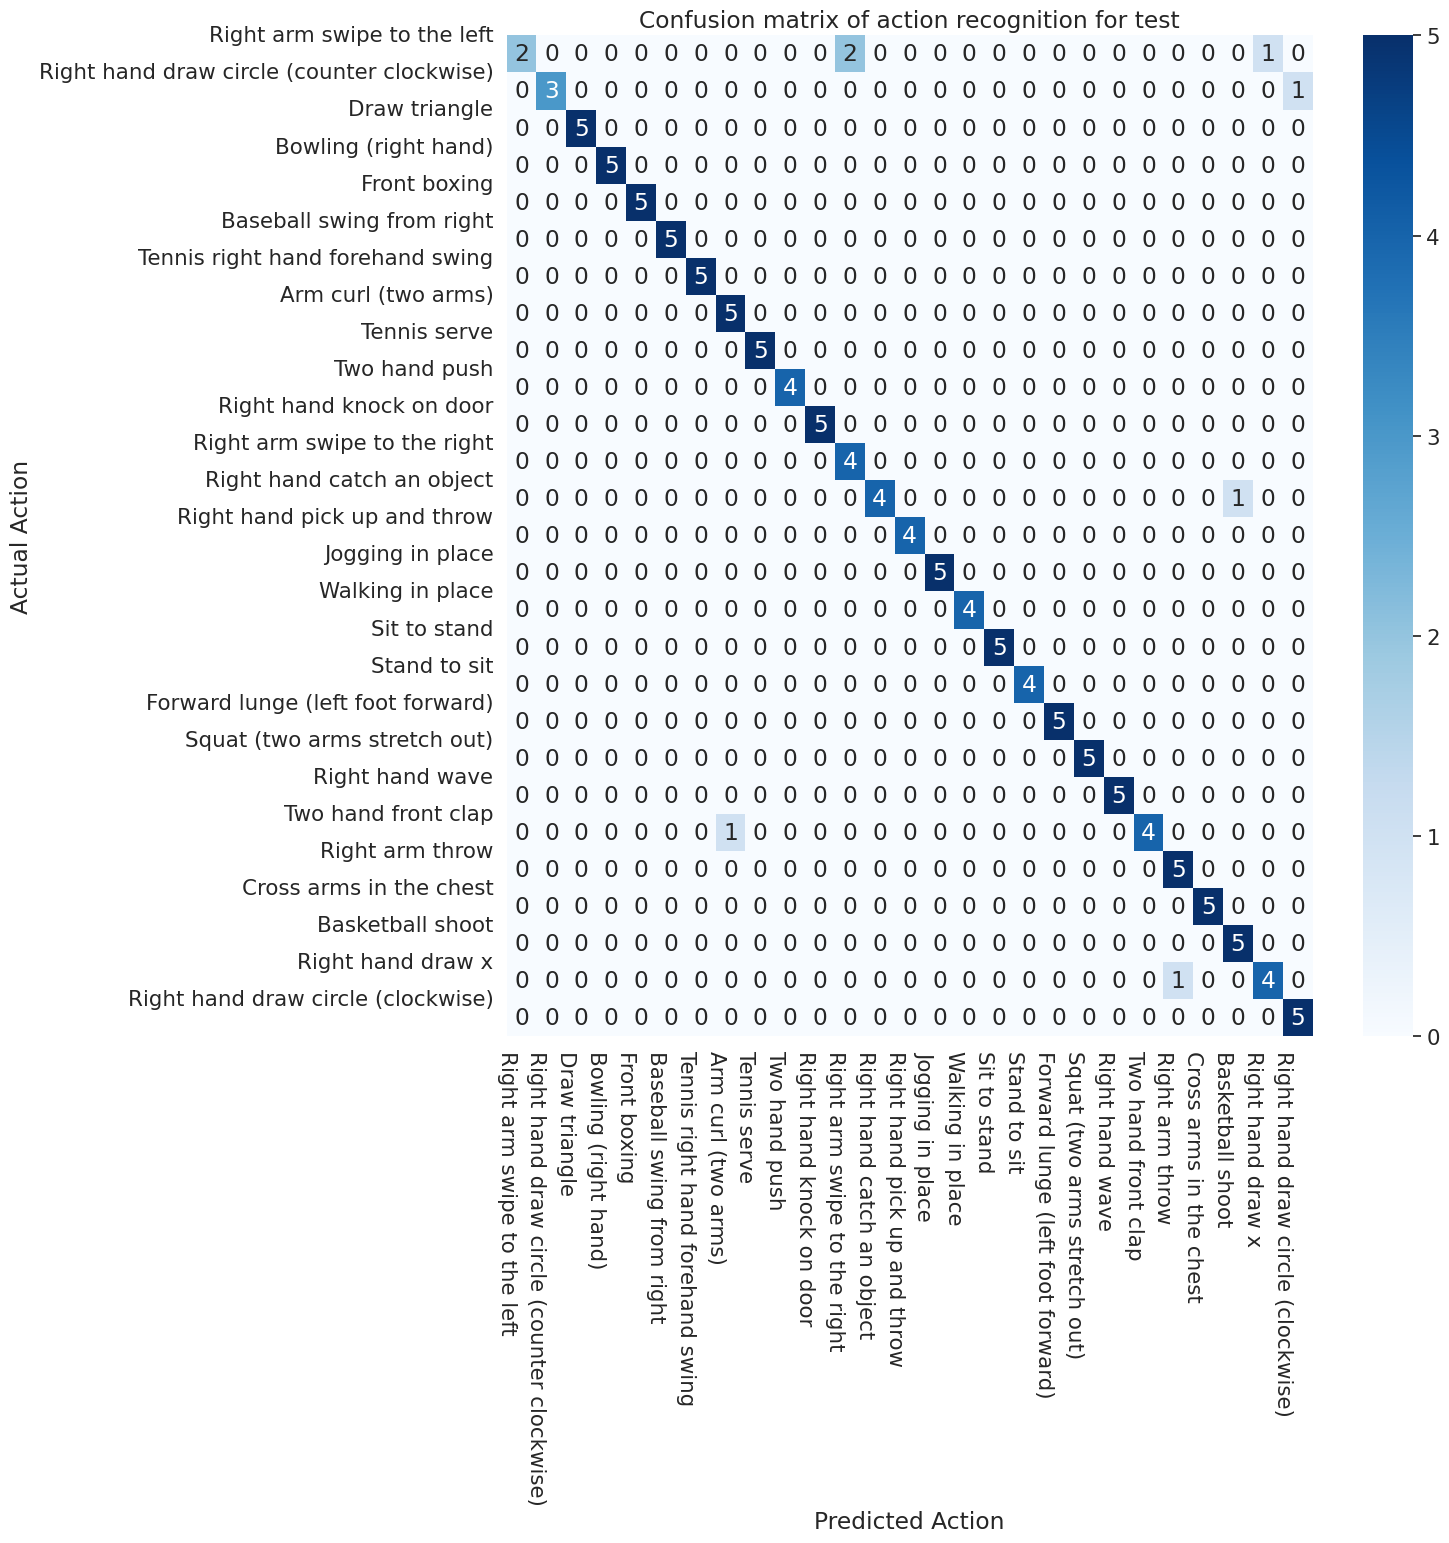

In [125]:
plot_confusion_matrix(actual, predicted, label_names, 'test')

In [21]:
model.save('/content/gdrive/MyDrive/sem7btp/movineta1.h5')

In [35]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False
# net = net(tf.keras.layers.Flatten())
# cnn = tf.keras.models.Sequential()
# cnn.add(net)
# cnn.add(tf.keras.layers.Flatten())

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.LSTM(30,return_sequences=True),
    # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu')),
    tf.keras.layers.Dense(len(action_cat)),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [36]:
model.fit(train_ds, 
          epochs = 20,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss'))

Epoch 1/20
151/151 [==============================] - 33s 140ms/step - loss: 4.4459 - accuracy: 0.1030 - val_loss: 4.1387 - val_accuracy: 0.1158
Epoch 2/20
151/151 [==============================] - 17s 112ms/step - loss: 3.2385 - accuracy: 0.2309 - val_loss: 3.4572 - val_accuracy: 0.2085
Epoch 3/20
151/151 [==============================] - 17s 112ms/step - loss: 2.8354 - accuracy: 0.3173 - val_loss: 3.3990 - val_accuracy: 0.2548
Epoch 4/20
151/151 [==============================] - 17s 113ms/step - loss: 2.4883 - accuracy: 0.3605 - val_loss: 2.9861 - val_accuracy: 0.2625
Epoch 5/20
151/151 [==============================] - 17s 113ms/step - loss: 2.2773 - accuracy: 0.4020 - val_loss: 2.6069 - val_accuracy: 0.3591
Epoch 6/20
151/151 [==============================] - 17s 113ms/step - loss: 2.1209 - accuracy: 0.4568 - val_loss: 2.3505 - val_accuracy: 0.3938
Epoch 7/20
151/151 [==============================] - 17s 112ms/step - loss: 1.8313 - accuracy: 0.5183 - val_loss: 2.1720 - val_ac

In [ ]:
train_data = np.load('/content/gdrive/MyDrive/sem7btp/utd_train_data_224_50.npy')
train_labels = np.load('/content/gdrive/MyDrive/sem7btp/utd_train_labels_224_50.npy')

In [ ]:
test_data = np.load('/content/gdrive/MyDrive/sem7btp/utd_test_data_224_50.npy')
test_labels = np.load('/content/gdrive/MyDrive/sem7btp/utd_test_labels_224_50.npy')

In [ ]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model.
    # _ = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=20,
    )

    _, accuracy, top_5_accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model


model = run_experiment()